<a href="https://colab.research.google.com/github/Sagar-modelling/XAI/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


It is helpful to remember the following points:

*Each feature has a shap value contributing to the prediction.

*The final prediction = the average prediction + the shap values of all features.

*The shap value of a feature can be positive or negative.

*If a feature is positively correlated to the target, a value higher than its own average will contribute positively to the prediction.

*If a feature is negatively correlated to the target, a value higher than its own average will contribute negatively to the prediction.


In [3]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import re
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

plt.rcParams['figure.figsize'] = [5, 5]
pd.set_option('display.max_columns', None)
import warnings
# model explainability use case
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix,plot_roc_curve
from lime.lime_tabular import LimeTabularExplainer
import shap
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Darshan10Sawant/Janatahack-Cross-sell-Prediction/master/train.csv')
df.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


In [ ]:
# getting the counts of each customer
for cols in df.columns:
    print('------------------------------------')
    print(df[cols].value_counts())
print('we have {} rows in our dataset'.format(df.shape[0]))
print('we have {} columns in our dataset'.format(df.shape[1]))

In [6]:
df['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

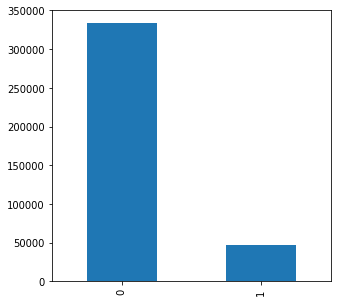

In [7]:
df['Response'].value_counts().plot(kind = 'bar')

In [7]:
# map them
df['Vehicle_Age'] = df['Vehicle_Age'].replace({'< 1 Year':1,'1-2 Year':2, '> 2 Years':3})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes':1, 'No':0})
df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})

In [9]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28,0,3,1,40454,26,217,1
1,2,1,76,1,3,0,2,0,33536,26,183,0
2,3,1,47,1,28,0,3,1,38294,26,27,1
3,4,1,21,1,11,1,1,0,28619,152,203,0
4,5,0,29,1,41,1,1,0,27496,152,39,0


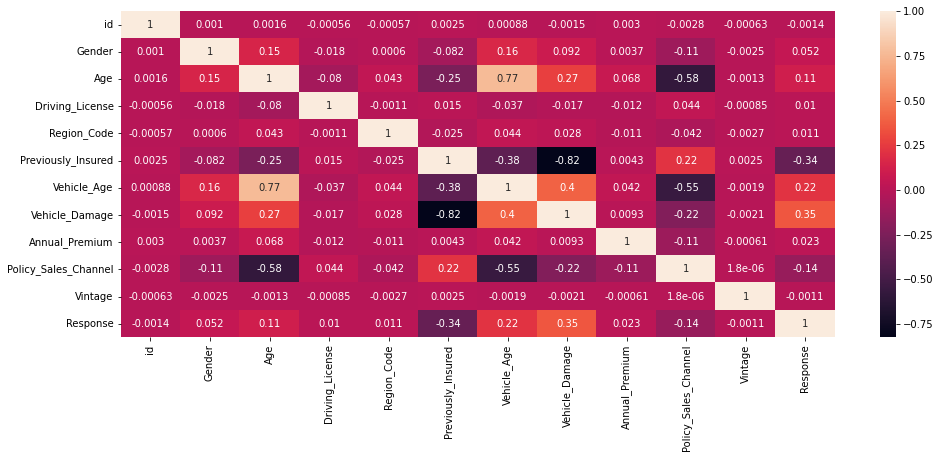

In [10]:
plt.figure(figsize = (16,6))
sns.heatmap(df.corr(), annot = True)

In [8]:
X = df.drop(["Response", 'id'], axis=1)
y = df["Response"]
# spliting the data to train and validation set
# train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101,stratify=y)
# shape of the data of train and validation set
print('Shape of the X_train {}'.format(X_train.shape))
print('Shape of the y_train {}'.format(y_train.shape))
print('Shape of the X_test {}'.format(X_test.shape))
print('Shape of the y_test {}'.format(y_test.shape))

Shape of the X_train (285831, 10)
Shape of the y_train (285831,)
Shape of the X_test (95278, 10)
Shape of the y_test (95278,)


In [9]:
params = {}
params["objective"] = "binary"
params['metric'] = 'auc'
params["max_depth"] = -1
params["num_leaves"] = 10
params["min_data_in_leaf"] = 20
params["learning_rate"] = 0.03
params["bagging_fraction"] = 0.9
params["feature_fraction"] = 0.35
params["feature_fraction_seed"] = 20
params["bagging_freq"] = 10
params["bagging_seed"] = 30
params["'min_child_weight'"] = 0.09
params["lambda_l1"] = 0.01
params["verbosity"] = -1
from lightgbm import LGBMClassifier # intializing the model
model = LGBMClassifier(**params)
# fitting the model
model.fit(X_train, y_train)

LGBMClassifier("'min_child_weight'"=0.09, bagging_fraction=0.9, bagging_freq=10,
               bagging_seed=30, feature_fraction=0.35, feature_fraction_seed=20,
               lambda_l1=0.01, learning_rate=0.03, metric='auc',
               min_data_in_leaf=20, num_leaves=10, objective='binary',
               verbosity=-1)

Train AUC: 0.8520157116107662, Val Auc: 0.8507237820307436
AUC score of the model is 0.8507237820307436


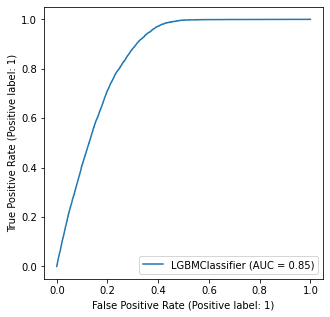

In [45]:
def model_auc(model):
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    val_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Train AUC: {train_auc}, Val Auc: {val_auc}')
# model performance
model_auc(model)
# predicting the likelihood for the validation set
y_pred = model.predict_proba(X_test)[:, 1]
# checking the roc_auc_curve
print('AUC score of the model is {}'.format(roc_auc_score(y_test, y_pred)))
# the visualization of roc_auc score
plot_roc_curve(model, X_test, y_test)

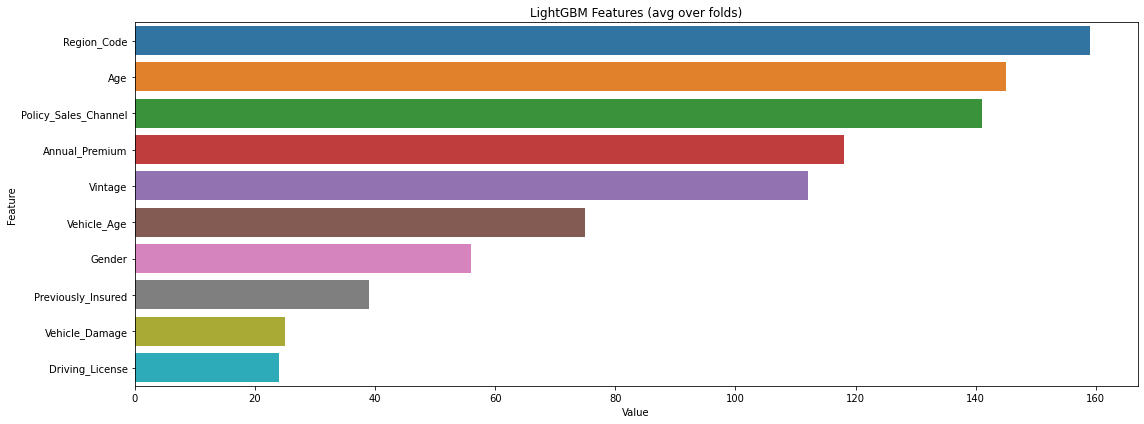

<Figure size 360x360 with 0 Axes>

In [46]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(16, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

# LIME Variable Importance Plot

In [37]:
from lime.lime_tabular import LimeTabularExplainer
class_names = [0, 1]
#instantiate the explanations for the data set
limeexplainer = LimeTabularExplainer(X_test.values, class_names=class_names, feature_names = X_test.columns, mode = 'classification')
idx=0 # the rows of the dataset
explainable_exp = limeexplainer.explain_instance(X_test.values[idx], model.predict_proba)

In [38]:
explainable_exp.show_in_notebook(show_table=True, show_all = False)

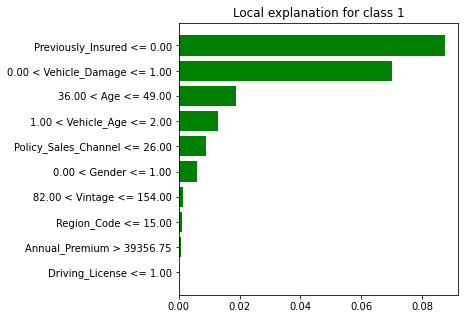

In [39]:
explainable_exp.as_pyplot_figure(); 
#Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.
#Previously_insiured=0: If it is previously insured it is highly correlated with the target

In [40]:
pd.DataFrame(explainable_exp.as_list())

,0,1
0,Previously_Insured <= 0.00,0.087378
1,0.00 < Vehicle_Damage <= 1.00,0.070093
2,36.00 < Age <= 49.00,0.018820
3,1.00 < Vehicle_Age <= 2.00,0.013026
4,Policy_Sales_Channel <= 26.00,0.008897
5,0.00 < Gender <= 1.00,0.006044
6,82.00 < Vintage <= 154.00,0.001382
7,Region_Code <= 15.00,0.001078
8,Annual_Premium > 39356.75,0.000631
9,Driving_License <= 1.00,0.000000


# SHAP Variable Importance Plot

In [23]:
explainer = shap.TreeExplainer(model)
idx = 100 # row selected for fast runtime
select = range(idx)
features = X_test.iloc[select]
feature_display = X.loc[features.index]
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

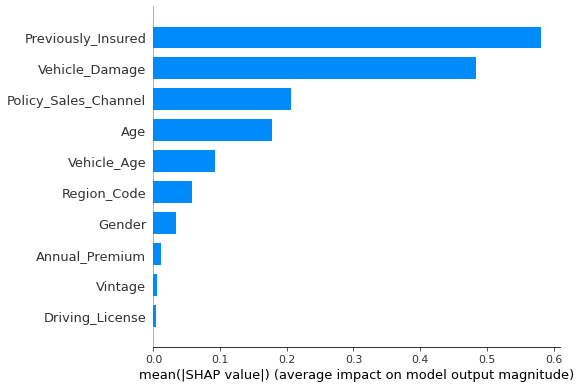

In [24]:
shap.summary_plot(shap_values, feature_display, plot_type = 'bar')

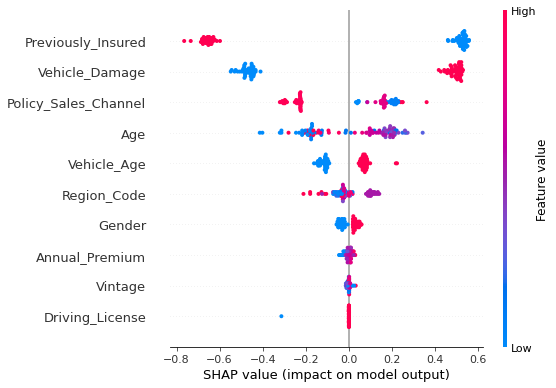

In [26]:
shap.summary_plot(shap_values, features) #shows the +ve and _ve realtionships with the target variable

# SHAP Variable Dependence Plot

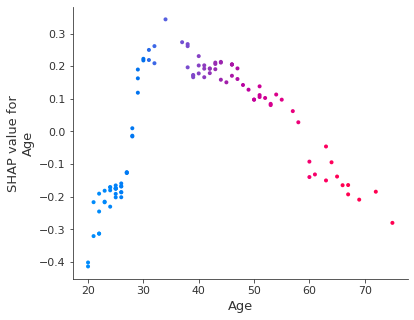

In [19]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                    shap_values=shap_values, features=X_test[:idx],
                    display_features=feature_display)

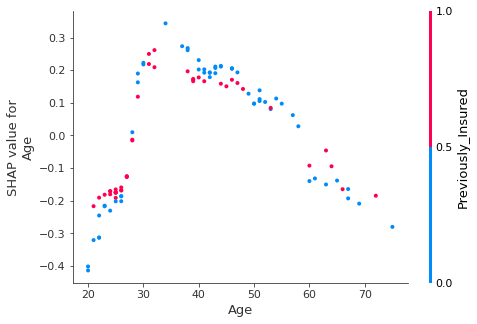

In [20]:
shap.dependence_plot(ind='Age', interaction_index='Previously_Insured',
                    shap_values=shap_values, features=X_test[:idx],
                    display_features=feature_display)

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


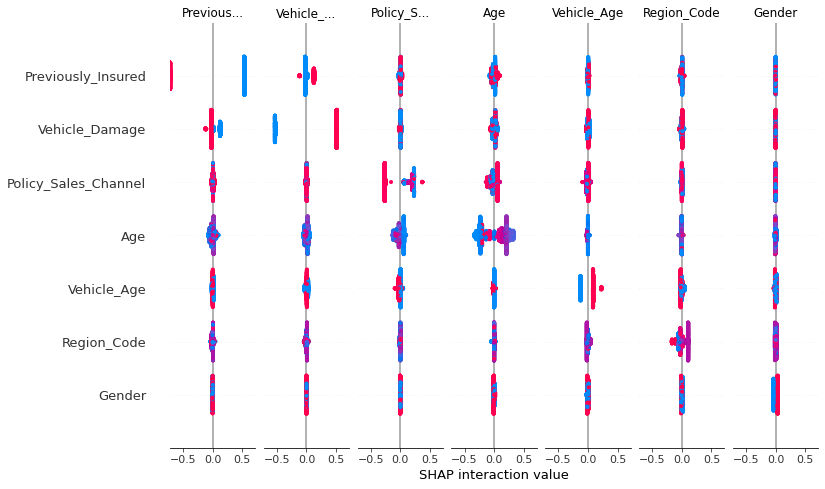

In [27]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train.iloc[:2000,:])
shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])

# Individual SHAP value Plot

In [30]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer Expected Value: {expected_value}")

Explainer Expected Value: -2.5286681811754854


In [31]:
shap.initjs() # run to show the force plot
shap.force_plot(explainer.expected_value, shap_values=shap_values[0,:], features=feature_display.iloc[0,:])
"""Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue"""
"""Expected value is the mean prediction, or mean(yhat).The mean prediction of Y_test is -2.529. You can test it out by Y_test.mean() which produces -2.529"""

In [35]:
shap.initjs() # run to show the force plot
shap.force_plot(explainer.expected_value, shap_values=shap_values[1,:], features=feature_display.iloc[1,:])

In [33]:
X_train.mean() #shap_values

Gender                      0.540270
Age                        38.821741
Driving_License             0.997855
Region_Code                26.363830
Previously_Insured          0.457840
Vehicle_Age                 1.610158
Vehicle_Damage              0.505047
Annual_Premium          30596.844104
Policy_Sales_Channel      112.099146
Vintage                   154.368550
dtype: float64

In [43]:
y_test.mean()

0.12256764415709817

In [32]:
shap.initjs() # run to show the plot
shap.force_plot(explainer.expected_value, shap_values, feature_display)

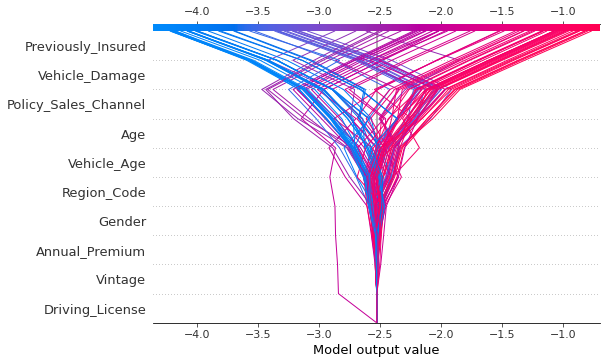

In [23]:
shap.decision_plot(expected_value, shap_values, features)

In [10]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
